In [1]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import numpy as np
import mobilityapp as ma

# Step by step

## Import and arrange data

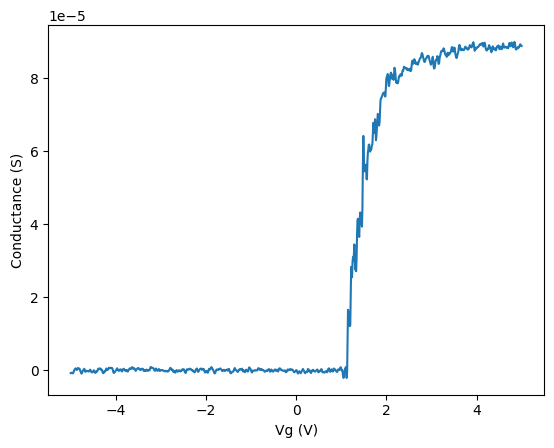

In [6]:
data=np.loadtxt('exampledata.dat')

Vg=data[0]
G=data[1]*7.748091729e-5 # This data was recorded in units of 2e2/h, but we need S. Delete conductance quantum if not needed

#Vg=Vg[::-1]   #If you have p-type devices!!! Please uncomment this line to reverse the order of Vg
            #Otherwise the derivative changes sign and skews differently; it's then impossible to set starting parameters for the fit.

if Vg[-1]<Vg[0]:  #Similarly, it's easier to just make sure Vg is ascending, even for n-type devices.
    Vg=Vg[::-1]
    G=G[::-1]
    
plt.plot(Vg,G)
plt.xlabel('Vg (V)')
plt.ylabel('Conductance (S)')
plt.show()

## Take the derivative, perform a fit to find the inflection point

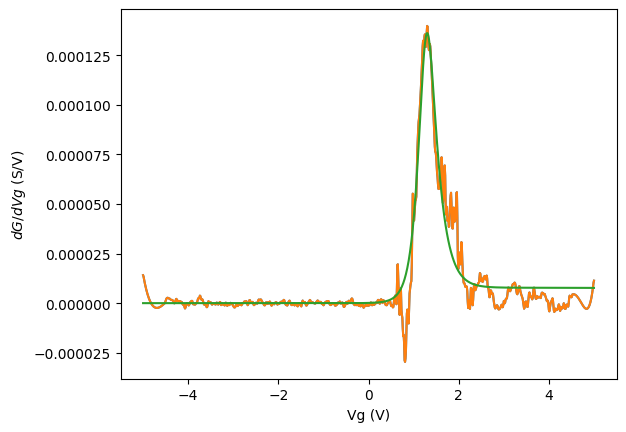

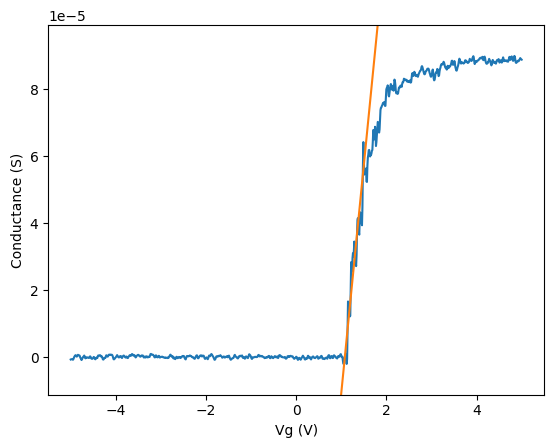

In [7]:
# When taking a numerical derivative, it's often necessary to smooth the data to avoid noise dominating
# To make it easy to understand, we can normalise the smoothing amount to the gate voltage range,
# i.e. smoothing should be a number between 0 and 1

smoothing = 0.1

if smoothing!=0:
    Gsmooth=savgol_filter(G, int(G.shape[0]*smoothing), 5, deriv=0, delta=1.0, axis=-1, mode='interp', cval=0.0)
    dGdVg = np.gradient(Gsmooth, Vg)
else:
    Gmooth=0 #Necessary since the function still expects something for Gsmooth
    dGdVg = np.gradient(G, Vg)

# If you need to restrict the data to a particular Vg range, specify it here. Otherwise write Vmin='Min', Vmax='Max'
Vmin=-3  #'Min'
Vmax=4  #'Max'

plt.plot(Vg,dGdVg)

#We now can send all the information to the function that performs the fit, and get a bunch of information back
V0,Vth,Vg_infl,V_Rs,inflectionline,deriv_fit,result_deriv_fit=ma.perform_deriv_fit(Vg,G,dGdVg,Gsmooth,smoothing,Vmin=Vmin,Vmax=Vmax)

# Plot both the fit and the line tangential to the inflection point to make sure it looks sensible.
# It's really important to check here that the tangent line looks sensible. Any error here can propagate.
# If it looks bad, perhaps you need to change the amount of smoothing, or the Vg range.

plt.plot(Vg,dGdVg)
plt.plot(Vg,deriv_fit)
plt.xlabel('Vg (V)')
plt.ylabel('$dG/dVg$ (S/V)')
plt.show()

plt.plot(Vg,G)
plt.plot(Vg,inflectionline)
plt.xlabel('Vg (V)')
plt.ylabel('Conductance (S)')
plt.ylim([G.min()-(G.max()-G.min())/10,G.max()+(G.max()-G.min())/10])
plt.show()

## Find the series resistance

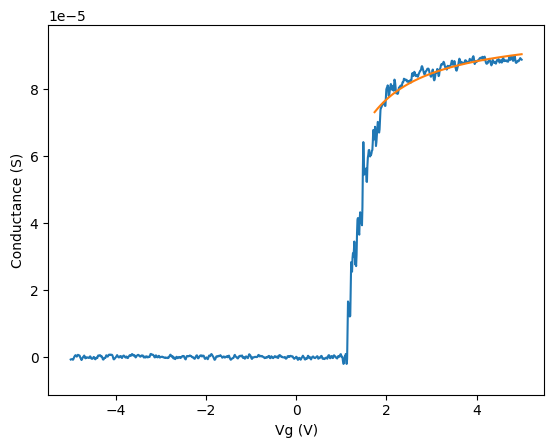

In [8]:
#To calculate the effective mobility and density, we need to know the series resistance Rs. 
#To find Rs, we use the Drude model only at large Vg, where Rs is large compared to the device resistance
#We now need to know a few more things...
L = 3.6e-6   #Device/gate length in meters
C = 5.3e-15  #Gate capacitance in farad
initial_Rs = 10000  #A rough guess for Rs in Ohm, to give the fit somewhere to start. 1/G_max is a good guess...
initial_mu = 0.4    #A rough guess for mu in m^2/(Vs). Note!! Not cm^2

Rs,Rs_fit,V_Rs_ind,result_drudeRs=ma.perform_Rs_fit(Vg,G,V0,V_Rs,initial_Rs,initial_mu,L,C)

#Check that the fit looks good. If not, try to change the initial guesses
plt.plot(Vg,G)
plt.plot(Vg[V_Rs_ind:],Rs_fit)
plt.xlabel('Vg (V)')
plt.ylabel('Conductance (S)')
plt.ylim([G.min()-(G.max()-G.min())/10,G.max()+(G.max()-G.min())/10])
plt.show()

## Calculate effective mobility and density

C:\Users\dc\AppData\Local\Temp\ipykernel_118092\1398555694.py:12: RuntimeWarning: divide by zero encountered in divide
  mu_eff=L**2/(C*(Vg-V0)*((1/G)-Rs))


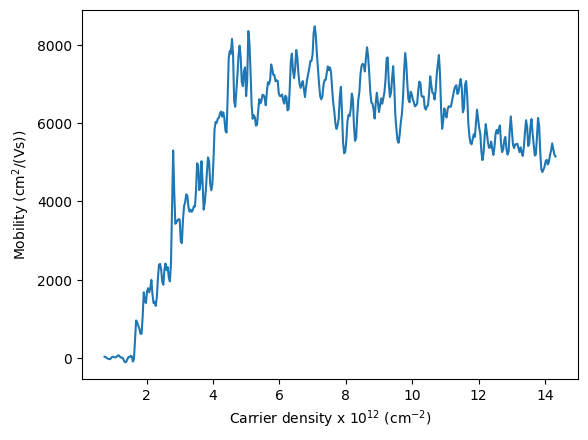

In [9]:
#To calculate the density, we need to know the capacitance per area.
#If you have a rectangular device, and know the channel/gate width, it's easy
#If you have e.g. a backgated nanowire, you need to know the capacitance per area from a simulation/calculation.
#Uncomment the below as necessary

# CperA=5.2e-3

width=280e-9
CperA = C/(L*width)

density=CperA*(Vg-V0)/1.602176634e-19
mu_eff=L**2/(C*(Vg-V0)*((1/G)-Rs))

plotstart=(np.abs(Vg - (2*Vth-Vg_infl))).argmin()
plt.plot(density[plotstart:]*1e-12/1e4,mu_eff[plotstart:]*1e4)
plt.xlabel('Carrier density x 10$^{12}$ (cm$^{-2}$)')
plt.ylabel('Mobility (cm$^2$/(Vs))')
plt.show()

## Perform a drude fit

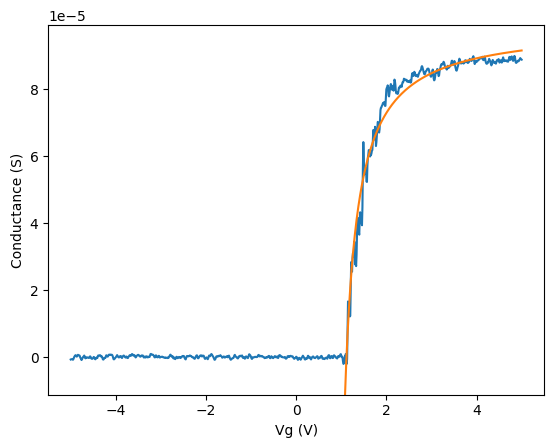

In [10]:
# If you really want to do it the old way, you can.

mu_drude,drude_fit,Rs_drude,Vth_ind,result_drude=ma.perform_drude_fit(Vg,G,Vth,initial_Rs,initial_mu,L,C)

plt.plot(Vg,G)
plt.plot(Vg[Vth_ind:],drude_fit)
plt.xlabel('Vg (V)')
plt.ylabel('Conductance (S)')
plt.ylim([G.min()-(G.max()-G.min())/10,G.max()+(G.max()-G.min())/10])
plt.show()

result_drude 
#Note; the lmfit results were returned for each previous fit as well
#If the fitting isn't going well, it can be very helpful to print the fit results.
#It may help guide towards better initial guesses.

# All in one go

C:\git\MobilityApp\mobilityapp\supportfunctions.py:210: RuntimeWarning: divide by zero encountered in divide
  mu_eff=L**2/(C*(Vg-V0)*((1/G)-Rs))


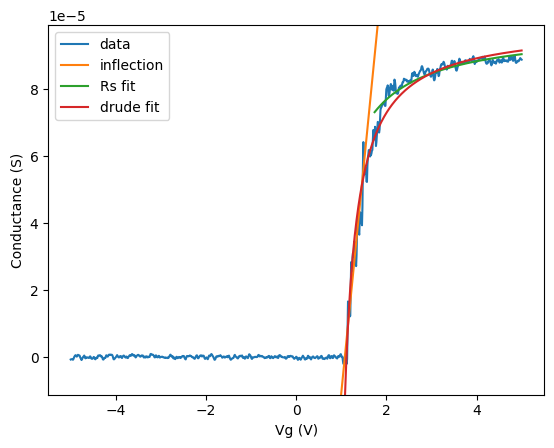

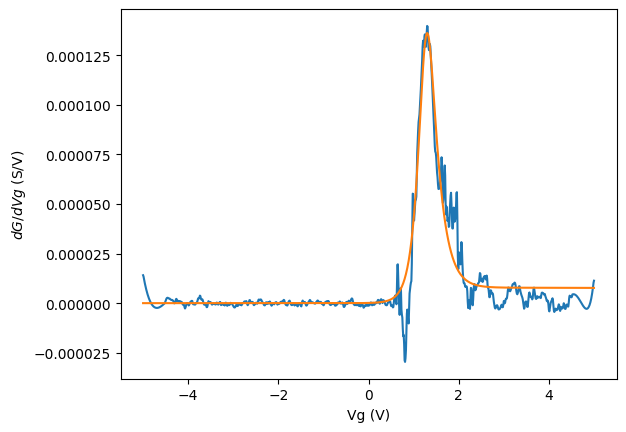

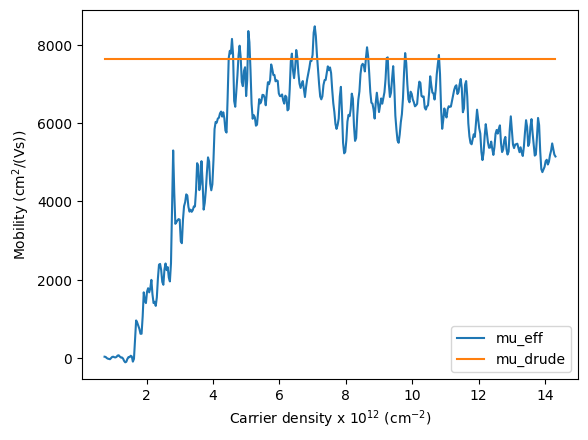

In [7]:
#If you know all your parameters in advance, and the fitting is working well, you can batch process results.
data=np.loadtxt('exampledata.dat')
Vg=data[0]
G=data[1]*7.748091729e-5
smoothing=0.1
Vmin=-4
Vmax=4
L = 3.6e-6
C = 5.3e-15
CperA=C/(L*280e-9)
initial_Rs = 10000
initial_mu = 0.4

datadict,paramdict=ma.perform_entire_prodecure(Vg,G,smoothing,Vmin,Vmax,L,C,CperA,initial_Rs,initial_mu,plotting=True)

#The function returns two dictionaries; one with all the data, and one with all the parameters, just like in the GUI.

# For the very curious (or frustrated?!)

In [ ]:
# Here are the functions used throughout, if you should need to edit them
# You will need to import from lmfit
from lmfit import Model, Parameters, minimize